(SARIMAX, VAR)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import yfinance as yf
from datetime import datetime, timedelta


In [2]:
import scipy.stats
import pylab

In [3]:
from statsmodels.tsa.arima.model import ARIMA

In [4]:
from pmdarima.arima import auto_arima

In [5]:
from arch import arch_model

In [6]:
from statsmodels.tsa.api import VAR

In [7]:
n_years = 10
years_in_days = n_years * 365

start_date = (datetime.today() - timedelta(days=years_in_days)).strftime("%Y-%m-%d")

In [8]:
index_symbols = ['SPY', 'QQQ', 'VUG', 'IWF', 'XLF', 'IJR']

data = yf.download(index_symbols, start=start_date)

[*********************100%***********************]  6 of 6 completed


In [9]:
adj_close = data['Adj Close'].asfreq('b', 'ffill')

In [10]:
# rets = adj_close.pct_change()
# cum_rets = rets.apply(lambda x: x.add(1, fill_value=0).cumprod() - 1)
# cum_value = rets.apply(lambda x: x.add(1, fill_value=0).cumprod() * 100)

rets = 100 * adj_close.pct_change()


In [11]:
# split train - test
size = int(len(rets)*0.8)
train_df_r, test_df_r = rets.iloc[:size], rets.iloc[size:]
train_df_p, test_df_p = adj_close.iloc[:size], adj_close.iloc[size:]

Fit model

In [12]:
# AR(1) - price
ar_mod = ARIMA(train_df_p['SPY'], order=(1,0,0))
ar_results = ar_mod.fit()

In [13]:
# AR(1) - rets
ar_mod_r = ARIMA(train_df_r['SPY'], order=(1,0,0))
ar_results_r = ar_mod_r.fit()

In [14]:
# MA(1) - rets
ma_mod_r = ARIMA(train_df_r['SPY'], order=(0,0,1))
ma_results_r = ma_mod_r.fit()

In [15]:
# ARMA(1,1) - rets
arma_mod_r = ARIMA(train_df_r['SPY'], order=(1,0,1))
arma_results_r = arma_mod_r.fit()

In [16]:
# ARMAX(1,1) - rets
arma_mod_r = ARIMA(train_df_r['SPY'][1:], exog=train_df_r[['QQQ', 'VUG', 'XLF']][1:], order=(1,0,1))
arma_results_r = arma_mod_r.fit()

In [17]:
# SARMA - rets
sarma_mod_r = ARIMA(train_df_r['SPY'][1:], order=(3,0,4), seasonal_order=(3,0,2,5))
sarma_results_r = sarma_mod_r.fit()

C:\Users\filip\Anaconda3\envs\TFc\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [18]:
#SARIMAX rets
sarmax_mod_r = ARIMA(train_df_r['SPY'][1:], exog=train_df_r[['QQQ', 'VUG', 'XLF']][1:], order=(3,0,4), seasonal_order=(3,0,2,5))
sarmax_results_r = sarmax_mod_r.fit()

C:\Users\filip\Anaconda3\envs\TFc\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [19]:
# Auto-arima - rets
aut_arima_mod = auto_arima(train_df_r['SPY'][1:], exogenous=train_df_r[['QQQ', 'VUG', 'XLF']][1:],
                          m=5, max_p=5, max_q=5, max_P=5, max_Q=5)

Forecasting

In [21]:
start_d = (train_df_r.index[-1] + timedelta(days=1)).strftime('%Y-%m-%d')
end_d = test_df_r.index[-1].strftime('%Y-%m-%d')

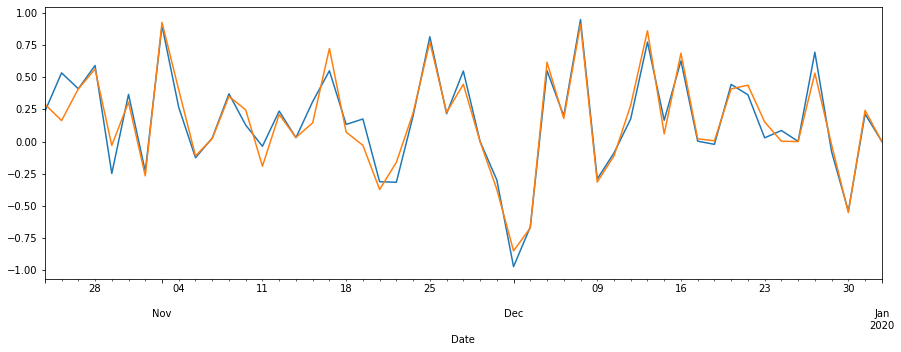

In [22]:
# ARMAX (1,1) - rets - RES
# ok in-sample pred but..

armax_pred = arma_results_r.predict(start=start_d, end=end_d, exog=test_df_r[['QQQ','VUG','XLF']])
armax_pred[start_d:'2020-01-01'].plot(figsize=(15,5))
test_df_r.SPY[start_d:'2020-01-01'].plot()

In [23]:
arma_results_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    SPY   No. Observations:                 2086
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1149.335
Date:                Thu, 21 Oct 2021   AIC                          -2284.670
Time:                        16:52:51   BIC                          -2245.169
Sample:                    10-25-2011   HQIC                         -2270.197
                         - 10-22-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.003      0.531      0.596      -0.004       0.007
QQQ           -0.0185      0.007     -2.632      0.008      -0.032      -0.005
VUG            0.6978      0.008     87.827      0.000       0.682       0.713
XLF            0.2267      0.004     53.685      0.000       0.218       0.235
ar.L1          0.1682      0.165      1.019      0.308      -0.155       0.492
ma.L1         -0.2859      0.163     -1.752      0.080      -0.606       0.034
sigma2         0.0195      0.000     43.314      0.000       0.019       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             64772.04
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.12
Prob(H) (two-sided):                  0.09   Kurtosis:                        30.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

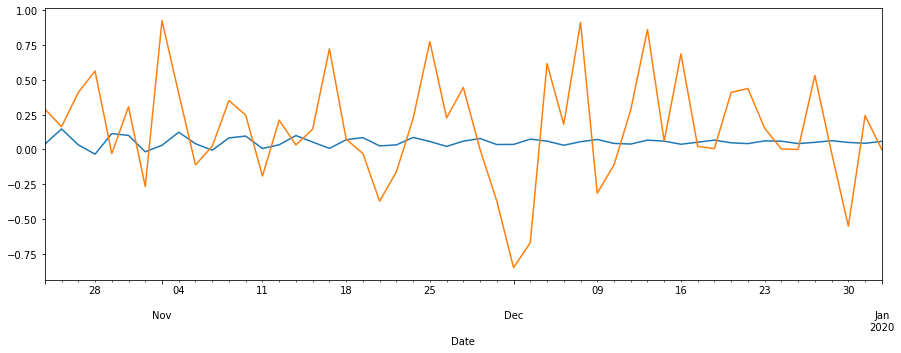

In [24]:
# SARMA -rets
sarma_pred = sarma_results_r.predict(start=start_d, end=end_d)
sarma_pred[start_d:'2020-01-01'].plot(figsize=(15,5))
test_df_r.SPY[start_d:'2020-01-01'].plot()

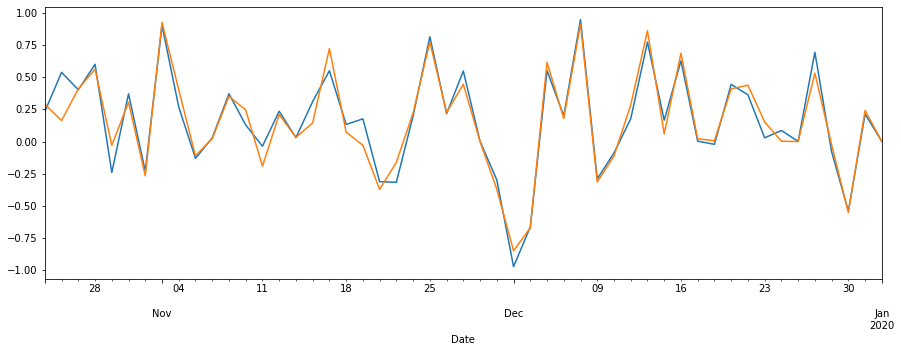

In [25]:
# SARIMAX
sarmax_pred = sarmax_results_r.predict(start=start_d, end=end_d, exog=test_df_r[['QQQ','VUG','XLF']])
sarmax_pred[start_d:'2020-01-01'].plot(figsize=(15,5))
test_df_r.SPY[start_d:'2020-01-01'].plot()

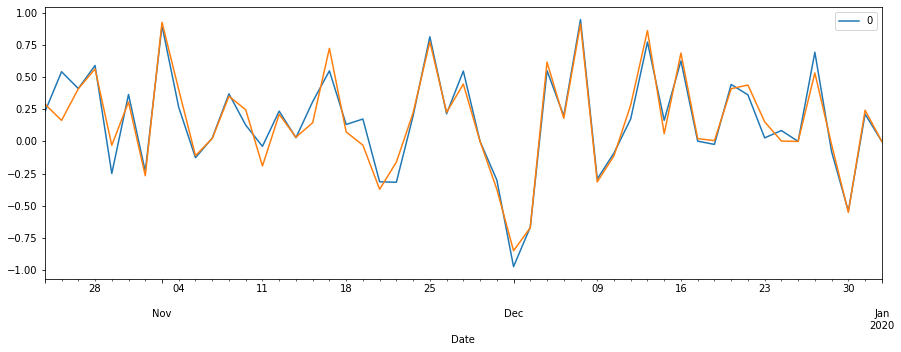

In [26]:
# auto arima - rets 
aut_arima_pred = pd.DataFrame(aut_arima_mod.predict(n_periods=len(test_df_r), exogenous=test_df_r[['QQQ', 'VUG', 'XLF']]), index=test_df_r.index)

aut_arima_pred[start_d:'2020-01-01'].plot(figsize=(15,5))
test_df_r.SPY[start_d:'2020-01-01'].plot()

In [27]:
aut_arima_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2086
Model:               SARIMAX(0, 0, 1)   Log Likelihood                1148.694
Date:                Thu, 21 Oct 2021   AIC                          -2287.389
Time:                        16:52:58   BIC                          -2259.174
Sample:                    10-25-2011   HQIC                         -2277.051
                         - 10-22-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
QQQ           -0.0180      0.007     -2.567      0.010      -0.032      -0.004
VUG            0.6971      0.008     87.899      0.000       0.682       0.713
XLF            0.2271      0.004     54.002      0.000       0.219       0.235
ma.L1         -0.1195      0.007    -16.078      0.000      -0.134      -0.105
sigma2         0.0195      0.000     43.538      0.000       0.019       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             63772.68
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.12
Prob(H) (two-sided):                  0.09   Kurtosis:                        30.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

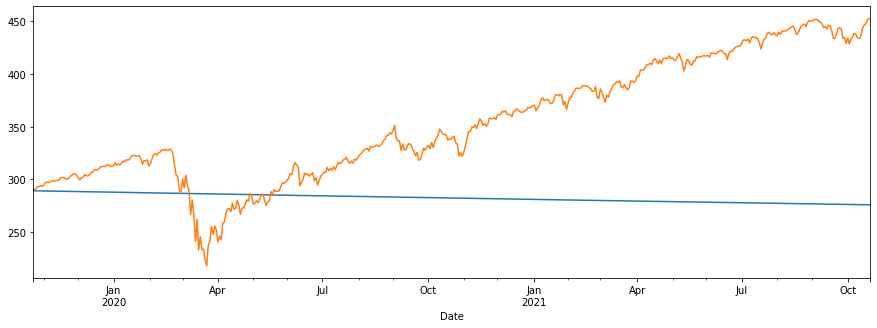

In [28]:
# AR(1) - price
pred_df = ar_results.predict(start=start_d, end=end_d)
pred_df.plot(figsize=(15,5))
test_df_p['SPY'].plot()

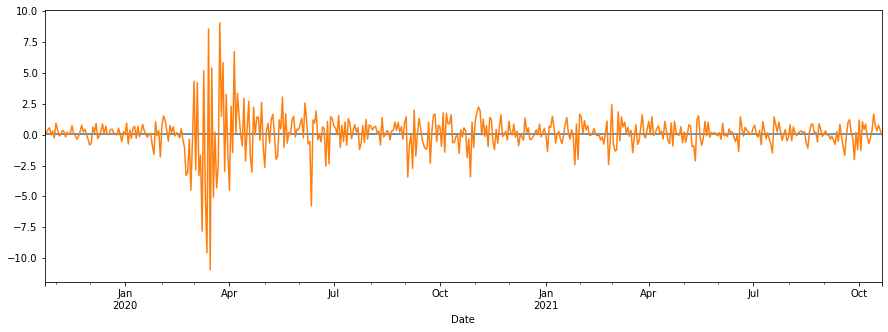

In [29]:
# AR(1) - rets
pred_df_r = ar_results_r.predict(start=start_d, end=end_d)
pred_df_r.plot(figsize=(15,5))
test_df_r['SPY'].plot()

In [30]:
ar_results_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    SPY   No. Observations:                 2087
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2562.875
Date:                Thu, 21 Oct 2021   AIC                           5131.750
Time:                        16:53:01   BIC                           5148.681
Sample:                    10-24-2011   HQIC                          5137.953
                         - 10-22-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0528      0.018      2.873      0.004       0.017       0.089
ar.L1         -0.0112      0.016     -0.697      0.486      -0.043       0.020
sigma2         0.6834      0.013     53.167      0.000       0.658       0.709
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1155.83
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.32
Prob(H) (two-sided):                  0.66   Kurtosis:                         6.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

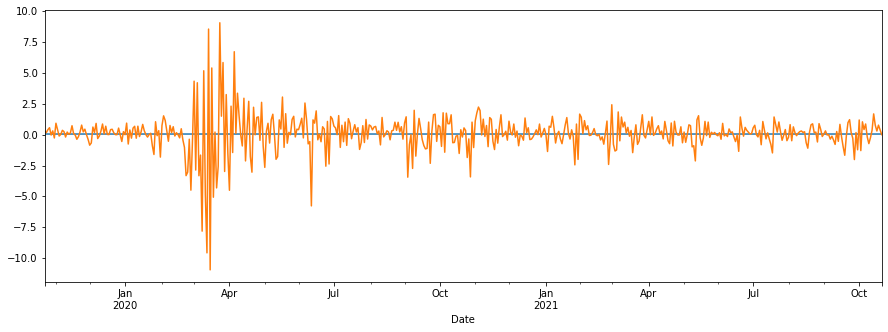

In [31]:
# MA res.
pred_df_ma = ma_results_r.predict(start=start_d, end=end_d)
pred_df_ma.plot(figsize=(15,5))
test_df_r['SPY'].plot()

In [32]:
## Pitfalls

# stationarity -> integrated models (can't plot actual)
# exog - endog

FORECAST VOLATILITY

In [33]:
# fit model

garch_mod = arch_model(rets['SPY'][1:], vol='GARCH', p=1, q=1, mean='constant', dist='normal')
garch_res = garch_mod.fit(last_obs=start_d, update_freq=10)

Iteration:     10,   Func. Count:     72,   Neg. LLF: 2318.4734062388834
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2318.471739996019
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12


In [34]:
pred_garch = garch_res.forecast(horizon=1, align='target', reindex=True)

In [35]:
pred_garch.residual_variance

,h.1
Date,
2011-10-25,NaN
2011-10-26,NaN
2011-10-27,NaN
2011-10-28,NaN
2011-10-31,NaN
...,...
2021-10-15,0.894787
2021-10-18,0.805829
2021-10-19,0.663084


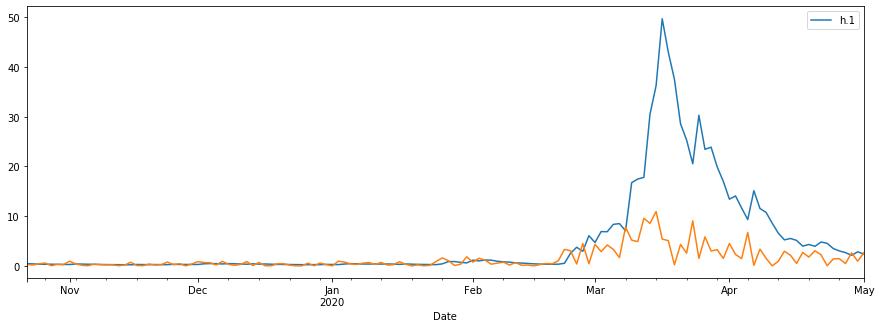

In [36]:
pred_garch.residual_variance[start_d:'2020-05-01'].plot(figsize=(15,5)) #zorder=2
test_df_r.SPY[start_d:'2020-05-01'].abs().plot() #zorder=1

In [37]:
pred_garch_100 = garch_res.forecast(horizon=100, align='target', reindex=True)
pred_garch_100.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-21,0.540129,0.637868,0.670773,0.793662,0.860157,0.568072,0.638729,0.714516,0.72185,0.811851,...,0.72949,0.729341,0.729478,0.72966,0.729857,0.72995,0.730107,0.730308,0.730506,0.730294


In [38]:
# VAR # VARMA models

In [39]:
rets_end = train_df_r[['SPY', 'QQQ', 'VUG', 'IWF', 'XLF', 'IJR']][1:]

In [40]:
rets_end

,SPY,QQQ,VUG,IWF,XLF,IJR
Date,,,,,,
2011-10-25,-1.944358,-1.966150,-1.982730,-1.900386,-2.980632,-2.694987
2011-10-26,1.015843,-0.122052,0.668828,0.680626,1.766535,1.615647
2011-10-27,3.483504,2.758828,3.192354,3.137471,5.962240,5.118107
2011-10-28,-0.023296,0.152904,0.329790,0.252105,0.071229,-0.316880
2011-10-31,-2.410608,-1.679658,-2.285183,-2.330266,-3.914616,-2.789087
...,...,...,...,...,...,...
2019-10-16,-0.160601,-0.248040,-0.301662,-0.320306,-0.249199,0.258121
2019-10-17,0.294908,0.264199,0.213588,0.333689,0.071375,1.132693
2019-10-18,-0.437720,-0.960996,-0.769649,-0.788355,0.249643,-0.623641


In [41]:
# fit model
var_mod = VAR(rets_end)
var_mod.select_order(maxlags=20)

var_results = var_mod.fit(ic='aic')

In [42]:
var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, Oct, 2021
Time:                     16:53:06
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -13.8971
Nobs:                     2085.00    HQIC:                  -13.9691
Log likelihood:          -3102.71    FPE:                8.22631e-07
AIC:                     -14.0108    Det(Omega_mle):     8.06253e-07
--------------------------------------------------------------------
Results for equation SPY
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.054550         0.018116            3.011           0.003
L1.SPY        -0.005840         0.151668           -0.039           0.969
L1.QQQ        -0.183217         0.077685           -2.358           0.018
L1.VUG         0

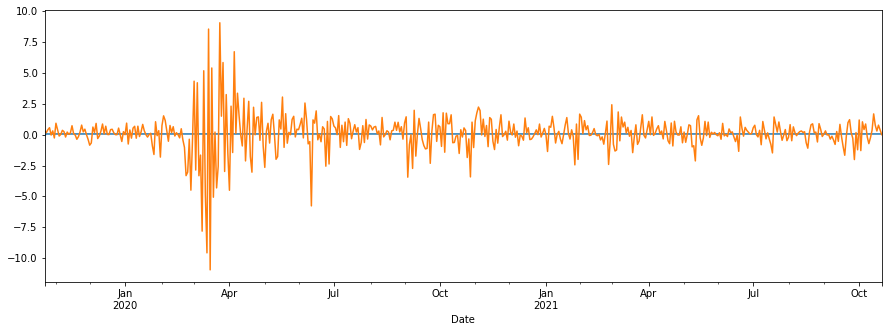

In [43]:
# forecast

lag_order = var_results.k_ar
var_pred = var_results.forecast(rets_end.values[-lag_order:], len(test_df_r[start_d:end_d]))

rets_pred = pd.DataFrame(data=var_pred, index=test_df_r[start_d:end_d].index, columns=test_df_r.columns)

rets_pred.SPY[start_d:end_d].plot(figsize=(15,5))
test_df_r.SPY[start_d:end_d].plot()

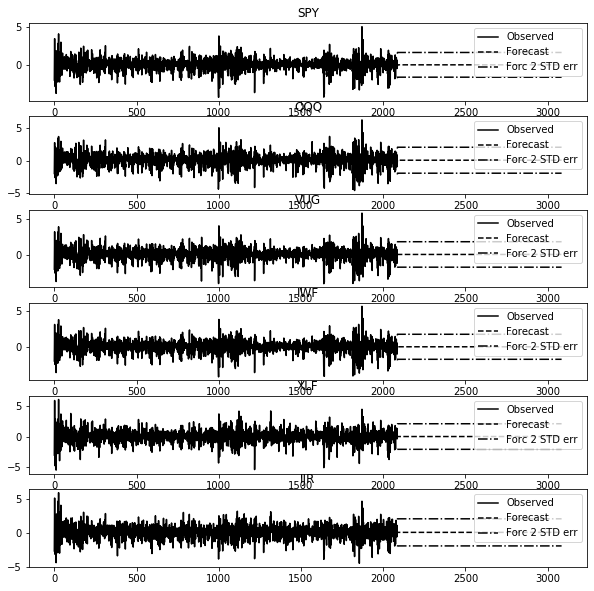

In [44]:
var_results.plot_forecast(1000)
plt.show()